In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v2
from timeit import default_timer as timer
from functools import partial

2025-09-29 05:37:06.266213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# CONST
BASE_DIR = "/home/maderya/skill_test_m2m/split_dataset2/"
INPUT_SIZE = (224,224)
BATCH_SIZE = 4
EPOCH = 150
SAVE_PATH = "/home/maderya/skill_test_m2m/models3/"
LABEL = ["front_right", "front_left", "rear_right", "rear_left", "hood"]
SIGMOID_THRESHOLD = 0.5

In [3]:

# Create Dataset 
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image,channels=3,expand_animations=False)
    image = tf.image.resize(images=image, size=INPUT_SIZE,preserve_aspect_ratio=False)
    image = tf.cast(image, tf.float32)/255.0
    # adjusted_image = tf.image.adjust_saturation(
    #     image, saturation_factor=0.2)
    # adjusted_image = tf.image.adjust_hue(
    #         adjusted_image, delta=-0.5)
    label = tf.cast(label,tf.float32)
    return image, label

def augmentation(image, label):
    image = tf.image.random_brightness(image=image, max_delta=0.1,seed=42)
    image = tf.image.random_contrast(image=image,lower=0.1, upper=0.2,seed=42)
    return image,label
    

# def get_augmentation_layer():
#     return tf.keras.Sequential([
#         tf.keras.layers.Rescaling(1./255),
#         tf.keras.layers.Resizing(224,224),
#         # tf.keras.layers.RandomZoom(0.1, 0.1),
#         # tf.keras.layers.RandomContrast(0.2),
#         tf.keras.layers.RandomBrightness(0.2,seed=42),
#     ], name="aug")
    

def create_dataset(csv_path :str, image_folder_name, shuffle = False, augment = False):
    df = pd.read_csv(csv_path)
    img_paths = df["image_path"].apply(
        lambda p: os.path.join(BASE_DIR, image_folder_name, p)
    ).tolist()   
    label = df[["front_right", "front_left", "rear_right", "rear_left", "hood"]]
    ds = tf.data.Dataset.from_tensor_slices((img_paths, label))
    ds = ds.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        ds = ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        # aug_layer = get_augmentation_layer()
        # ds = ds.map(lambda img, lbl: (aug_layer(img), lbl),
        #             num_parallel_calls=tf.data.AUTOTUNE)
        
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)
        
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = create_dataset(os.path.join(BASE_DIR ,"train.csv"),"train",shuffle=True, augment=False)
test_ds = create_dataset(os.path.join(BASE_DIR, "test.csv"), "test")
val_ds = create_dataset(os.path.join(BASE_DIR, "val.csv"), "val")


    

I0000 00:00:1759099031.690146  125553 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1295 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


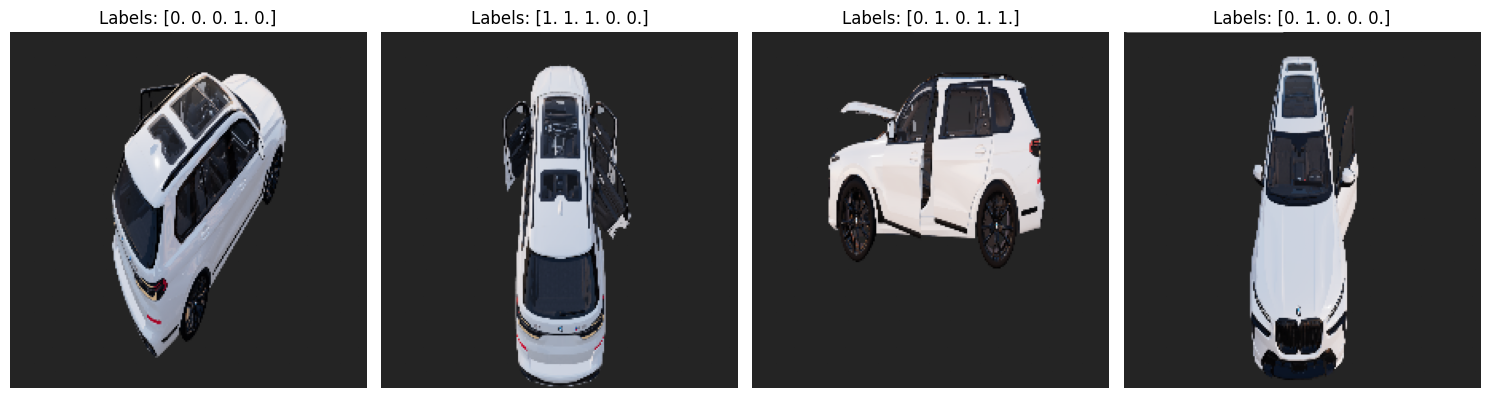

In [4]:
def visualize_batch(dataset, num_images=4):
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        # Convert tensor to numpy for plotting
        image_batch = images.numpy()
        label_batch = labels.numpy()

        # Plot images
        fig, axes = plt.subplots(1, min(num_images, len(image_batch)),
                                 figsize=(15, 4))

        for i in range(min(num_images, len(image_batch))):
            # Normalize image if needed (you already normalized to [0,1] via /255.0)
            ax = axes[i] if num_images > 1 else axes
            # squeeze removes extra dim if any
            ax.imshow(image_batch[i].squeeze())
            ax.set_title(f"Labels: {label_batch[i]}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        break  # Only show one batch
    

visualize_batch(train_ds)

In [30]:
base_model = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(*INPUT_SIZE,3))
base_model.trainable = False
# base_model.summary()

In [5]:
# create custom model as the backbone
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3,padding="same",kernel_initializer=tf.keras.initializers.he_normal)
custom_model = tf.keras.Sequential([
    DefaultConv2D(filters=32, kernel_size=7),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    DefaultConv2D(filters=64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten()

])

custom_model1 = tf.keras.Sequential([
    DefaultConv2D(filters=32, kernel_size=7),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten()

])

custom_model2 = tf.keras.Sequential([
    DefaultConv2D(filters=32, kernel_size=7),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(filters=512,kernel_size=3,use_bias=False),
    tf.keras.layers.SeparableConv2D(filters=512, kernel_size=3, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten()
])

In [7]:
custom_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,311,936 (8.82 MB)

 Trainable params: 2,308,288 (8.81 MB)

 Non-trainable params: 3,648 (14.25 KB)

In [6]:
# create full networks
#  --- Using Mobilenetv2 ---
# input = tf.keras.layers.Input(shape=(*INPUT_SIZE,3))
# x = base_model(input)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# output = tf.keras.layers.Dense(units=5, activation=tf.keras.activations.sigmoid)(x)
# model = tf.keras.Model(input,output)

# --- Using Custom CNN Model ---
input = tf.keras.layers.Input(shape=(*INPUT_SIZE, 3))
x = custom_model2(input)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(
    units=5,
    activation=tf.keras.activations.sigmoid,
    kernel_regularizer=tf.keras.regularizers.l2(0.03)
)(x)
model = tf.keras.Model(input, output)


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 12800)          │     2,311,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        64,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,375,941 (9.06 MB)

 Trainable params: 2,372,293 (9.05 MB)

 Non-trainable params: 3,648 (14.25 KB)

In [16]:
# callback function for training
class TimeCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start_time = None
        self.epoch_time = 0.0
        self.total_time = 0.0
        self.iter_count = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = timer()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_time = timer() - self.start_time
        self.total_time += self.epoch_time

    def on_train_batch_end(self, batch, logs=None):
        self.iter_count += 1

    def on_train_end(self, logs=None):
        print("\nAverage iteration time: {:.2f} ms".format(
            (self.total_time/self.iter_count) * 1000))
        print("Average epoch time: {:.2f} s".format(self.total_time/EPOCH))
        print("Total training time: {:.2f} s".format(self.total_time))

In [17]:
# optimizer setting
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["accuracy","precision","recall"]
)

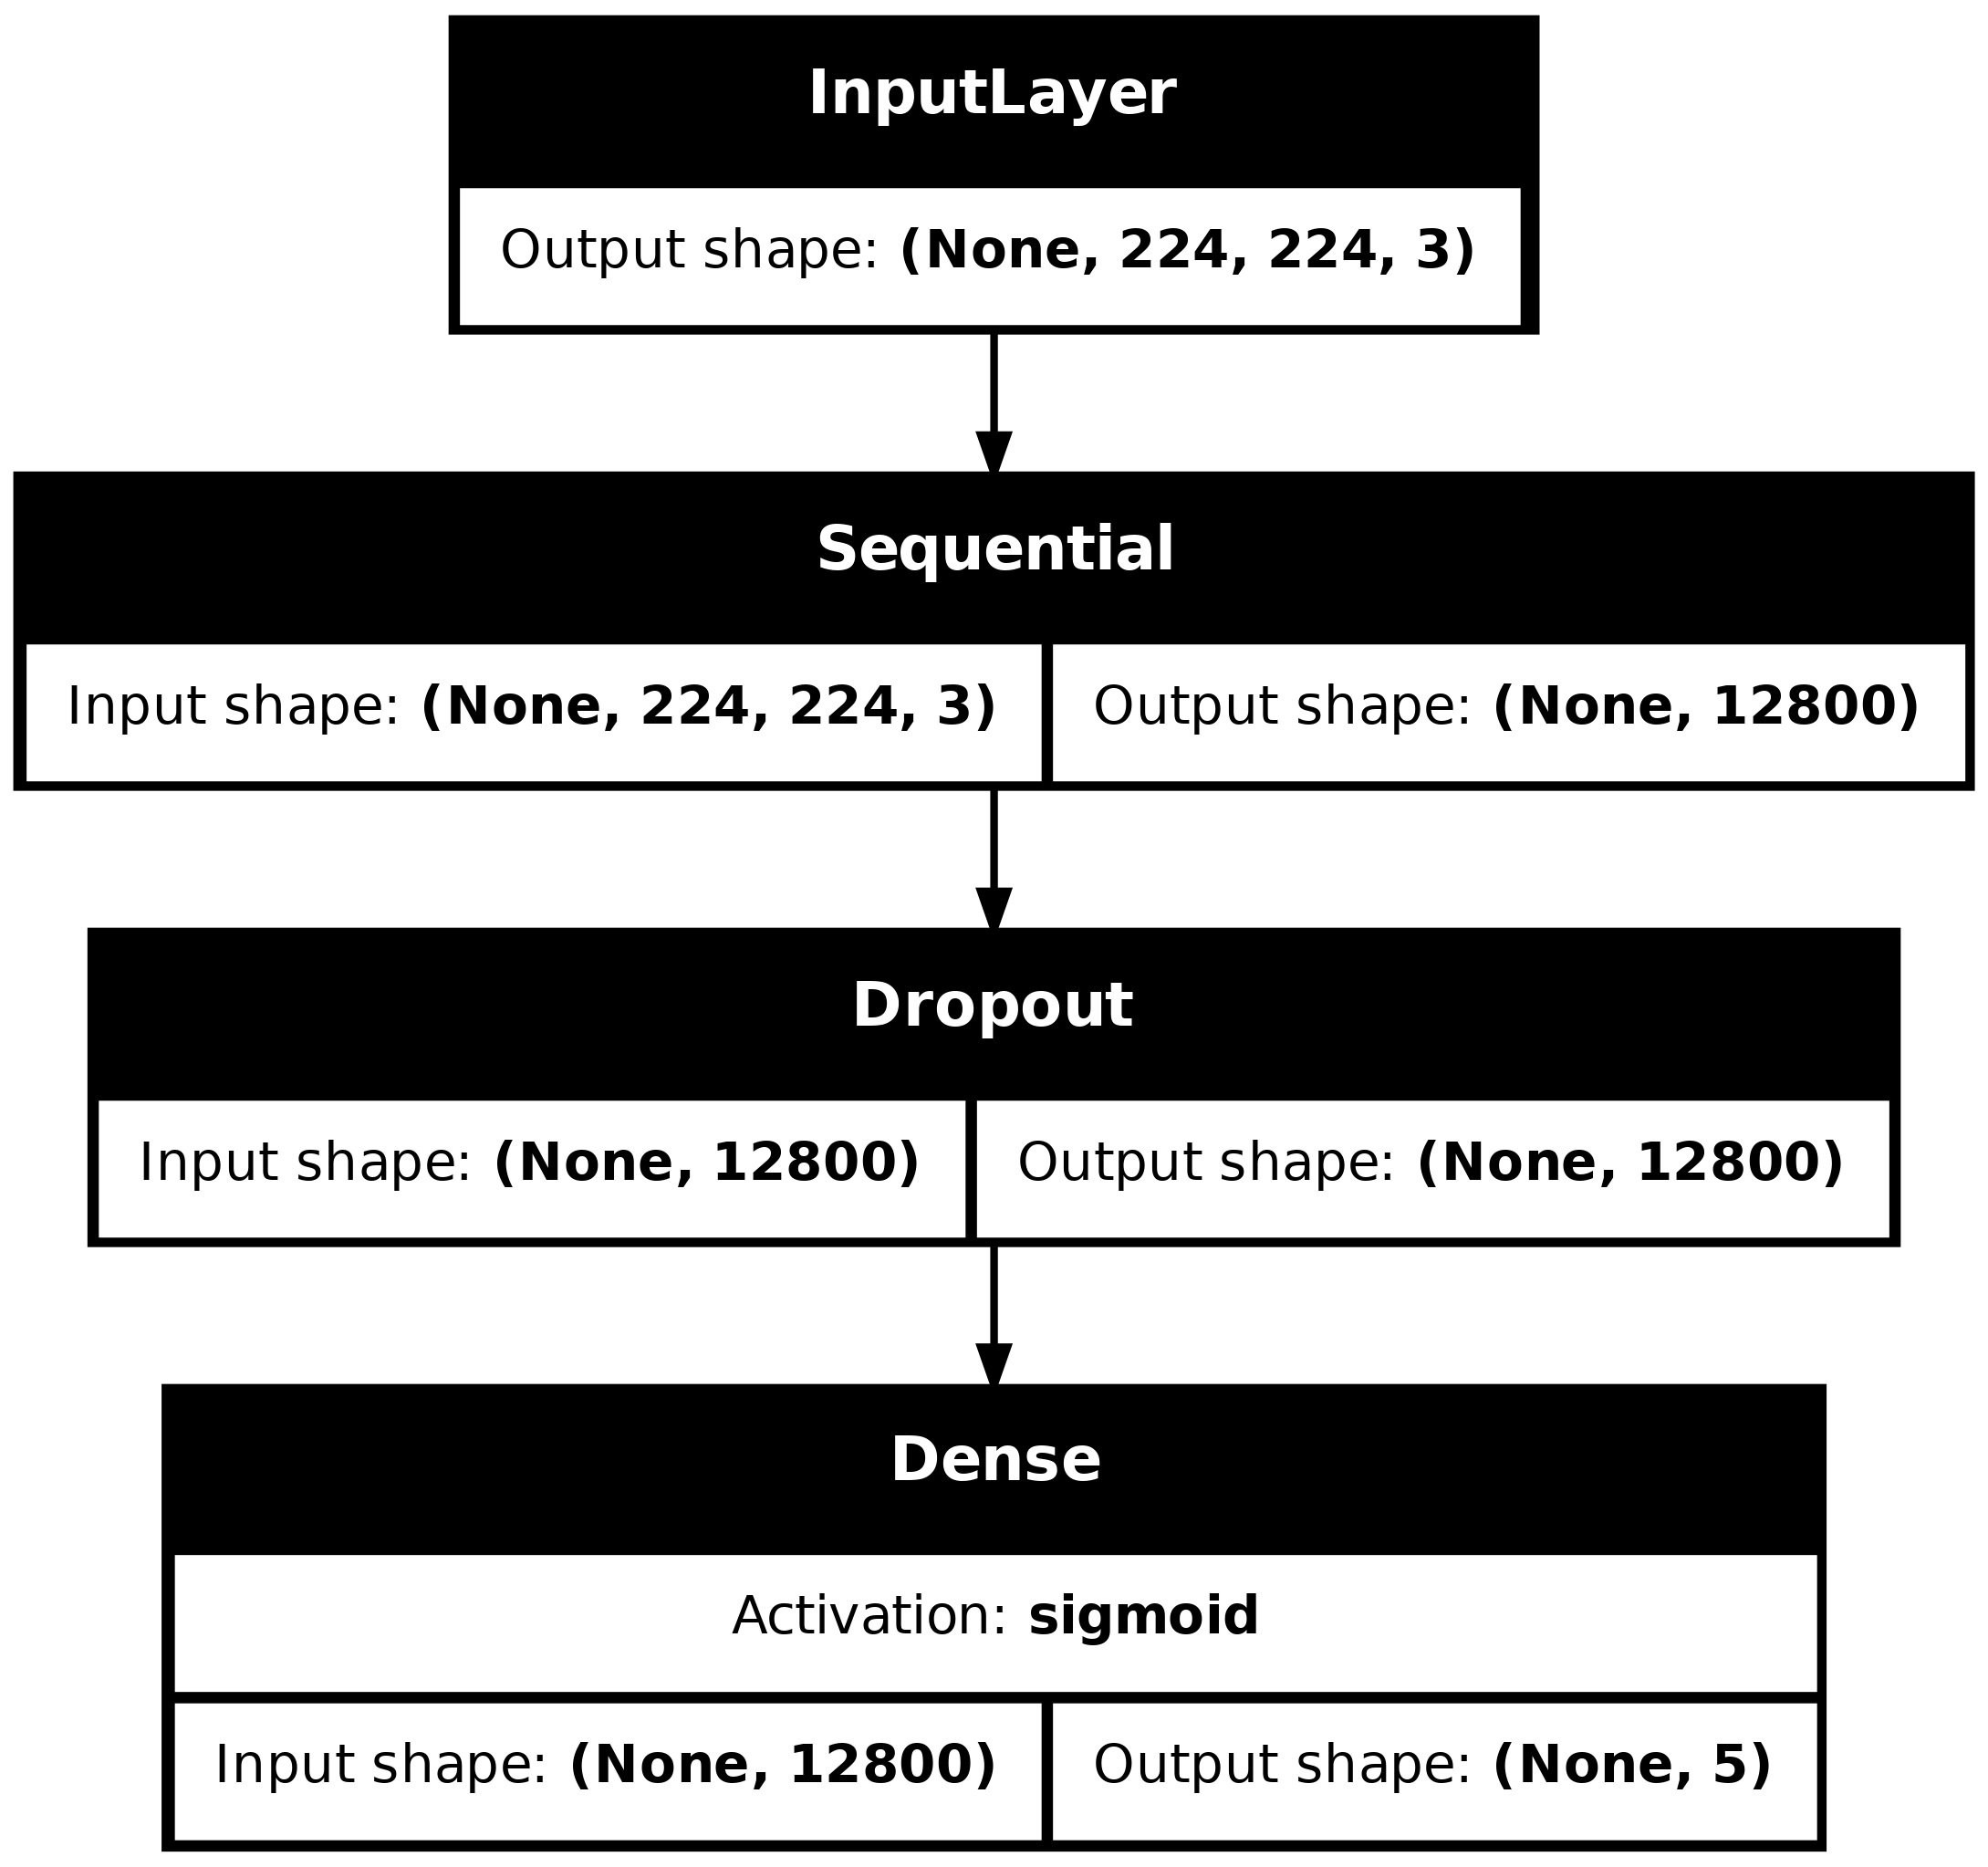

In [19]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=300,show_layer_activations=True)

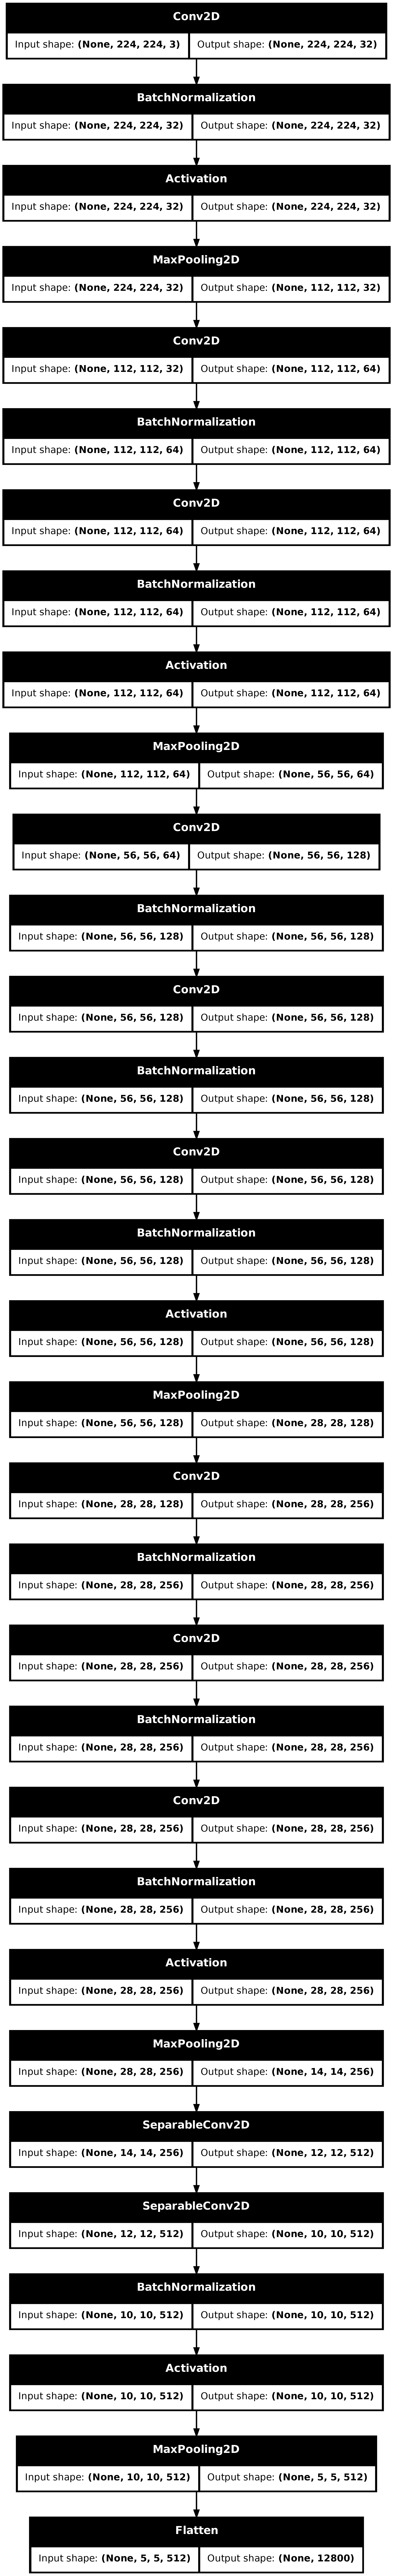

In [8]:
tf.keras.utils.plot_model(custom_model2,dpi=300,show_shapes=True,show_layer_activations=False)

In [23]:
# fit model
time_callback = TimeCallback()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=25, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    save_best_only=True, filepath=SAVE_PATH + "/checkpoint/best_model.keras")

hist = model.fit(
    train_ds,
    epochs=EPOCH,
    callbacks=[time_callback, early_stop, checkpoint],
    validation_data=val_ds
)

Epoch 1/150


2025-09-29 02:15:34.865738: I external/local_xla/xla/service/service.cc:163] XLA service 0x75238802abe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 02:15:34.865755: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-09-29 02:15:35.015350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 02:15:35.803791: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-29 02:15:36.857193: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[4,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

 2/64 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.0000e+00 - loss: 1.0861 - precision: 0.3889 - recall: 0.3268  

I0000 00:00:1759086953.317129   88886 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2164 - loss: 0.9996 - precision: 0.4566 - recall: 0.3515

2025-09-29 02:16:00.626489: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[3,256,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,128,28,28]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-29 02:16:00.879620: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[3,256,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,256,28,28]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.1843 - loss: 0.9409 - precision: 0.4822 - recall: 0.4336 - val_accuracy: 0.5818 - val_loss: 0.8401 - val_precision: 0.4978 - val_recall: 0.8615
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.2157 - loss: 0.7830 - precision: 0.5281 - recall: 0.4101 - val_accuracy: 0.1455 - val_loss: 0.7548 - val_precision: 0.5229 - val_recall: 0.4385
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.1765 - loss: 0.7225 - precision: 0.5547 - recall: 0.4941 - val_accuracy: 0.1818 - val_loss: 0.7340 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.2471 - loss: 0.7196 - precision: 0.5802 - recall: 0.4739 - val_accuracy: 0.1636 - val_loss: 0.7361 - val_precision: 0.5854 - val_recall: 0.1846
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2275 - loss: 0.7137 - precision: 0.5658 - recall: 0.4840 - val_accuracy: 0.0545 - val_loss: 0.73

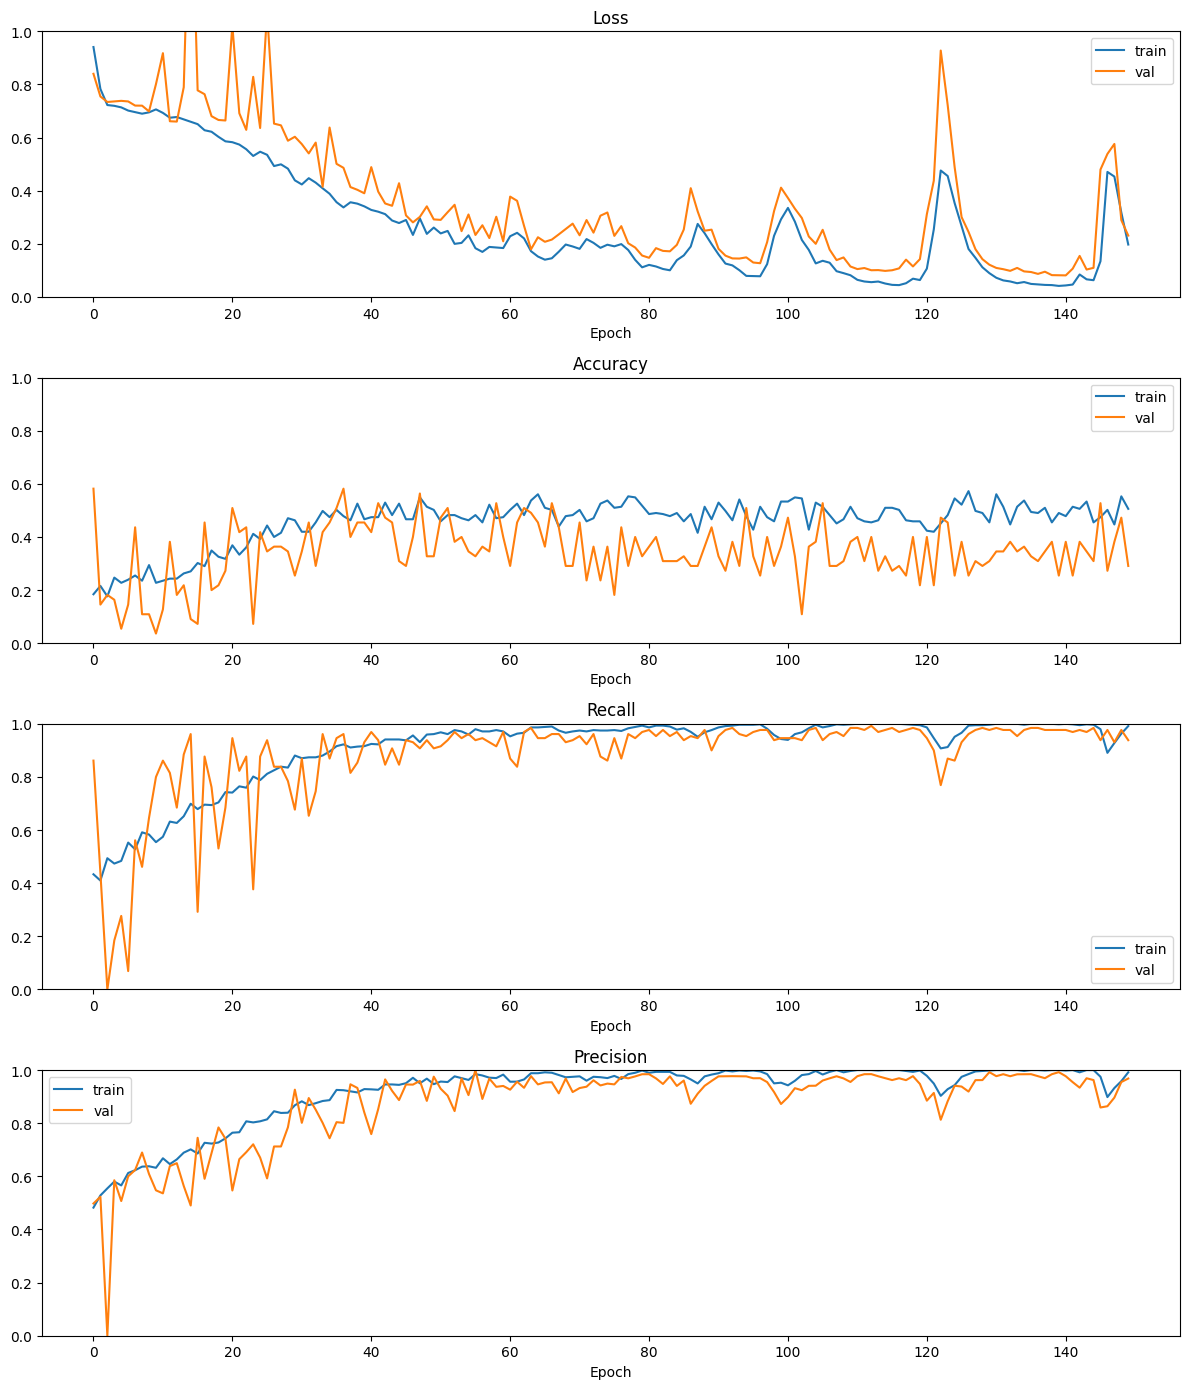

In [24]:
def plot_history(hist):
    # loss
    plt.figure(figsize=(12, 14))
    plt.subplot(4, 1, 1)
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.ylim(0, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='val')
    plt.ylim(0, 1)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(hist.history['recall'], label='train')
    plt.plot(hist.history['val_recall'], label='val')
    plt.ylim(0, 1)
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(hist.history['precision'], label='train')
    plt.plot(hist.history['val_precision'], label='val')
    plt.ylim(0, 1)
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()

plot_history(hist)

In [10]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_curve, auc, precision_recall_curve

# Get probabilities
y_prob = model.predict(val_ds)                     
y_true = np.concatenate([y for _, y in val_ds], axis=0)

# Binarise with a threshold 
y_pred = (y_prob >= SIGMOID_THRESHOLD).astype(int)

# Classification report (precision, recall, f1) – macro & micro
print(classification_report(y_pred=y_pred,y_true=y_true, target_names=[
    'front_right', 'front_left', 'rear_right', 'rear_left', 'hood'
]))


2025-09-29 06:19:51.487682: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ea0740101a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 06:19:51.487698: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-09-29 06:19:51.502599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 06:19:51.580450: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-29 06:19:52.345005: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[4,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

I0000 00:00:1759101595.940482  125869 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-09-29 06:19:57.844653: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[3,256,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,128,28,28]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-29 06:19:58.157264: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[3,256,28,28]{3,2,1,0}, u8[0]{0}) 

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step
              precision    recall  f1-score   support

 front_right       0.51      1.00      0.67        28
  front_left       0.46      0.96      0.62        26
  rear_right       0.44      1.00      0.61        24
   rear_left       0.45      1.00      0.62        25
        hood       0.41      0.26      0.32        27

   micro avg       0.46      0.84      0.60       130
   macro avg       0.45      0.84      0.57       130
weighted avg       0.46      0.84      0.57       130
 samples avg       0.46      0.77      0.56       130



2025-09-29 06:20:00.238204: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/maderya/anaconda3/envs/gpu_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


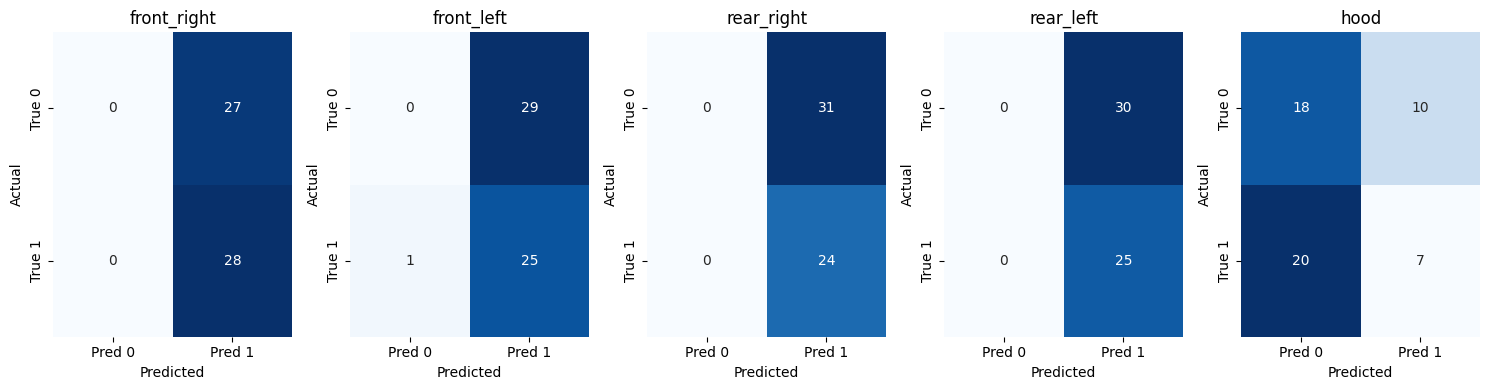

In [21]:
import seaborn as sns

cm = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'],
                ax=ax)
    ax.set_title(LABEL[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [27]:
# ---  Predict on new images ---
predictions = model.predict(val_ds)

# Each prediction is a vector of 5 values between 0 and 1
print("Predictions shape:", predictions.shape)  
print("Sample prediction:", predictions[0])
# print("prediction:", predictions)


# Convert probabilities to binary predictions (threshold = 0.5)
binary_predictions = (predictions > SIGMOID_THRESHOLD).astype(int)
# print("Binary predictions:", binary_predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predictions shape: (55, 5)
Sample prediction: [0.00144701 0.02956104 0.9968159  0.9944536  0.9493643 ]


In [28]:
# convert binary label into text label
def binary_to_label(binary_pred, label_name):
    for i, name in enumerate(label_name):
        if binary_pred[i] == 1 :
            print(f"{name} is open")
        else :
            print(f"{name} is closed")
    

result = binary_to_label(binary_predictions[0], LABEL)
result
                

front_right is closed
front_left is closed
rear_right is open
rear_left is open
hood is open


Images shape: (4, 224, 224, 3)
Labels shape: (4, 5)


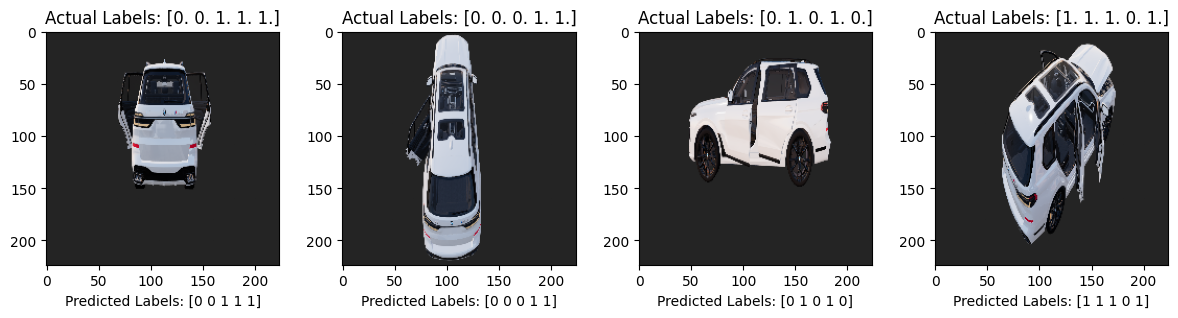

In [29]:
for image_batch, label_batch in val_ds:
    print("Images shape:", image_batch.shape)
    print("Labels shape:", label_batch.shape)

    # Plot first 4 images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        axes[i].imshow(image_batch[i].numpy().squeeze())
        axes[i].set_title(f"Actual Labels: {label_batch[i].numpy()}")
        axes[i].set_xlabel(f"Predicted Labels: {binary_predictions[i]}")
        axes[i].axis('on')
    plt.tight_layout()
    plt.show()
    break

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred,   average='micro')
f1_micro = f1_score(y_true, y_pred,       average='micro')

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred,   average='macro')
f1_macro = f1_score(y_true, y_pred,       average='macro')

print(f"Micro‑P/R/F1: {precision_micro:.3f}/{recall_micro:.3f}/{f1_micro:.3f}")
print(f"Macro‑P/R/F1: {precision_macro:.3f}/{recall_macro:.3f}/{f1_macro:.3f}")

Micro‑P/R/F1: 0.977/0.977/0.977
Macro‑P/R/F1: 0.978/0.977/0.978


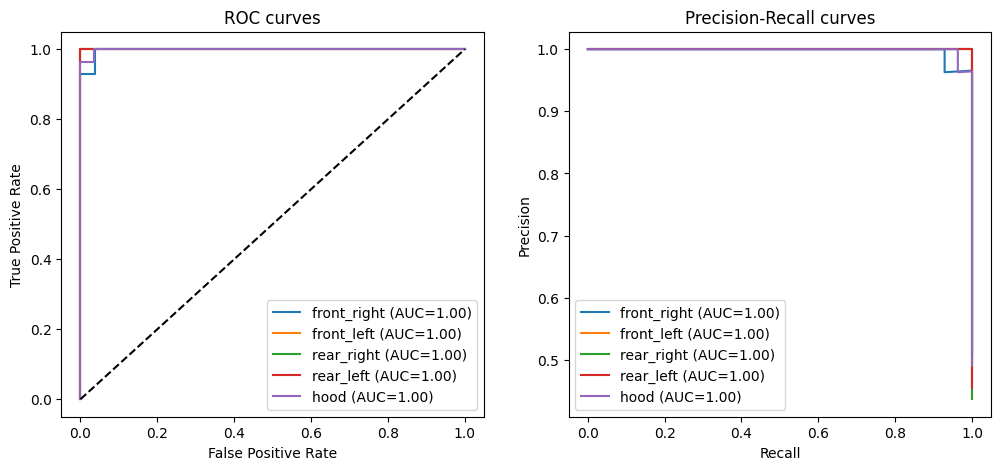

In [31]:
def plot_roc_pr(y_true, y_prob, class_names):
    n_classes = y_true.shape[1]
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # ROC
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        ax[0].plot(fpr, tpr, label=f'{class_names[i]} (AUC={roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC curves')
    ax[0].legend()

    # PR
    for i in range(n_classes):
        prec, rec, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
        pr_auc = auc(rec, prec)
        ax[1].plot(rec, prec, label=f'{class_names[i]} (AUC={pr_auc:.2f})')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision‑Recall curves')
    ax[1].legend()
    plt.show()


class_names = ['front_right', 'front_left', 'rear_right', 'rear_left', 'hood']
plot_roc_pr(y_true, y_prob, class_names)